In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import kurtosis
from scipy.stats import skew
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import itertools

/Users/jaemin/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Methods

In [2]:
# Show distplot
def show_displot(series_data, bins_num=50):
    sns.distplot(series_data, bins=bins_num)
    plt.show()
    
# Calculate prob for changing to standard
def getp(i,x):
    c = 3 
    a = len( train1[ (train1['var_'+str(i)]>x-s[i]/c)&(train1['var_'+str(i)]<x+s[i]/c) ] ) 
    b = len( train0[ (train0['var_'+str(i)]>x-s[i]/c)&(train0['var_'+str(i)]<x+s[i]/c) ] )
    #개수가 너무 작으면 0.1로 통일
    if a+b<500:
        return 0.1
    return a / (a+b)

# Calculate prob for new data
def getp2(i,x):
    z = (x-m[i])/s[i]
    ss = (rmax-rmin)/(res-1)
    if res%2==0: idx = min( (res+1)//2 + z//ss, res-1)
    else: idx = min( (res+1)//2 + (z-ss/2)//ss, res-1)
    idx = max(idx,0)
    return pr[i,int(idx)]


def cal_mean(raw):
    return raw.mean()
def cal_std(raw):
    return raw.std()
def cal_median(raw):
    return raw.median()
def cal_kurtosis(raw):
    return kurtosis(raw)
def cal_skew(raw):
    return skew(raw)
def cal_sum(raw):
    return sum(raw)


def preprocessing_data(x_df, y_df):
    
    x_df_copy = x_df.copy()
    y_df_copy = y_df.copy()
    x_df_min = x_df_copy.min()
    x_df_max = x_df_copy.max()
    x_df_range = x_df_max - x_df_min

    #Output DataFrame
    statistic_df = pd.DataFrame()
    reg_df = pd.DataFrame()

    #Create Statistic DataFrame
    statistic_df["mean"] = x_df_copy.apply(cal_mean, axis=1)
    statistic_df["std"] = x_df_copy.apply(cal_std, axis=1)
    statistic_df["median"] = x_df_copy.apply(cal_median, axis=1)
    statistic_df["kurtosis"] = x_df_copy.apply(cal_kurtosis, axis=1)
    statistic_df["skew"] = x_df_copy.apply(cal_skew, axis=1)
    statistic_df["sum"] = x_df_copy.apply(cal_sum, axis=1)
    statistic_df_min = statistic_df.min(axis=0)
    statistic_df_max = statistic_df.max(axis=0)
    statistic_df_range = statistic_df_max - statistic_df_min
    statistic_df  = (statistic_df-statistic_df_min)/statistic_df_range
    print("Creating Statistic DF is done")

    #Create Reg DataFrame
    reg_df = (x_df_copy-x_df_min)/x_df_range
    print("Creating Reg DF is done")

    #Output DF
    merge_data = pd.concat([reg_df, statistic_df], ignore_index=True, axis=1)
    cols = list(x_df.columns)+['mean','std','median','kurtosis','skew','sum']
    merge_data.columns= cols

    return merge_data, y_df_copy, x_df_min, x_df_range, statistic_df_min, statistic_df_range


# Showing confusion matrix
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Classification Modeling

### 목차

    1. 데이터 설명
    2. Train 데이터 전처리
    3. Test 데이터 전처리
    4. 모델링
    5. 결과

은행 고객에 대한 거래 데이터를 활용해서 미래에 은행과의 거래가 발생할지에 대해 예측하는 문제입니다.

Classification 모델을 활용하여 거래가 발생하지 않으면 0, 거래가 발생하면 1로 가정하여 분류를 시도했습니다.

# 1. Data Description

데이터 출처 : 캐글 오픈 데이터\
칼럼 설명 :
    1. ID_code : 레코드 ID
    2. target : 미래에 거래가 발생 했을 시 1, 그렇지 않으면 0
    3. var_0 ~ var_199 : 200개의 가려진 Feature

In [2]:
data = pd.read_csv("./Data/train.csv")
print(data.shape)
data.head()

(200000, 202)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


# 2. Data preprocessing

    1. 라벨 분포 확인
    2. Train, Test set 분리
    3. 데이터 분포 확인
    4. 확률변수 칼럼 생성
    5. 변수들의 통계량을 나타낸 칼럼 생성

### Label 분포

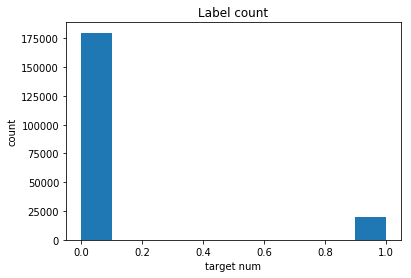

Target 0 : 179902
Target 1 : 20098


In [4]:
# Split Data (target=0, target=1)
train_0 = data[data.target==0]
train_1 = data[data.target==1]

plt.hist(data.target)
plt.xlabel("target num")
plt.ylabel("count")
plt.title("Label count")
plt.show()
print("Target 0 : "+ str(len(train_0)))
print("Target 1 : "+ str(len(train_1)))

Label 별로 분포가 크게 차이남을 확인

### Train, Test Set 분리

In [5]:
x_tr, x_te, y_tr, y_te = train_test_split(data[data.columns[2:]], data.target, stratify=data.target, test_size=0.2)

모델 테스트를 위한 데이터 셋 생성

Label의 비율을 유지하기 위해 "Stratify" 옵션 설정

### 데이터 분포 확인

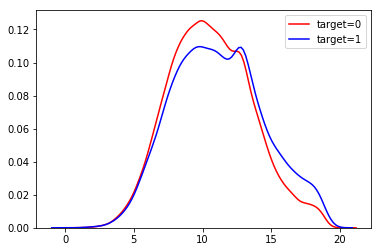

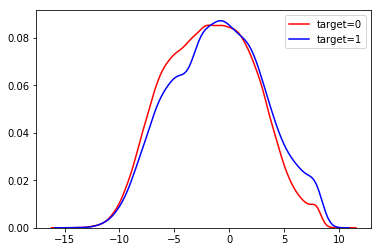

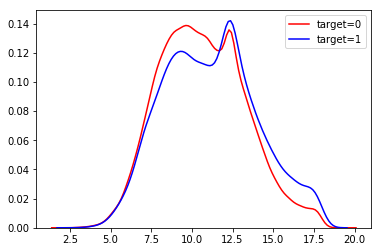

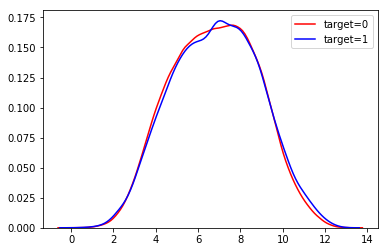

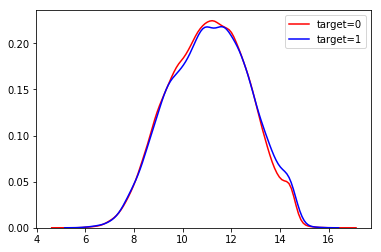

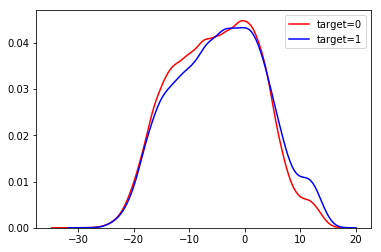

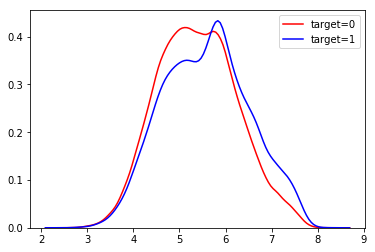

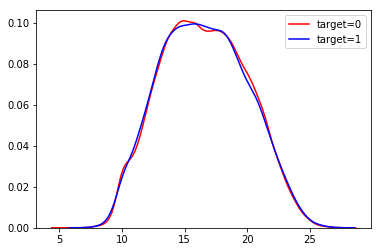

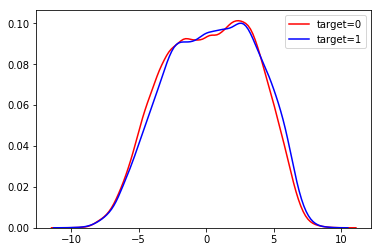

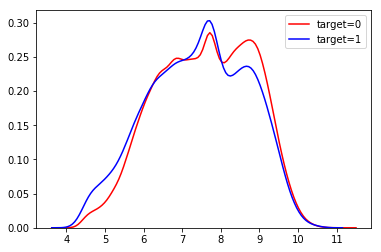

In [10]:
for ii in range(10):
    col_name = "var_"+str(ii)
    sns.kdeplot(train_0[col_name], label="target=0", color="r")
    sns.kdeplot(train_1[col_name], label="target=1", color="b")
    plt.show()

Feature 별로 분포가 크게 차이가 없지만 조금씩 차이가 있음을 확인

### 확률 변수로 이루어진 칼럼 생성

In [9]:
data = pd.concat([x_tr, y_tr], axis=1)
data.reset_index(drop=True, inplace=True)
data.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
0,12.9248,-5.9242,10.9951,5.6755,11.7568,-7.5574,6.9809,21.6180,-0.5645,8.7533,...,5.1136,1.0759,5.8310,16.8595,0.3097,-0.7388,9.6473,19.7046,7.9871,0
1,6.2985,2.1478,13.1880,8.8957,13.8445,-1.1356,5.7458,15.9428,5.7996,5.5210,...,5.8463,1.5311,-0.6920,17.8961,-0.7458,6.3326,9.7940,20.2961,13.7876,0
2,9.3502,-4.3999,13.3475,4.3429,12.0613,1.3467,4.4968,20.4413,4.3591,7.6068,...,9.8616,-0.6061,1.2730,21.4874,1.2873,-6.7823,9.8295,17.4760,-3.8782,0
3,4.4432,-0.6339,13.3387,6.4924,9.1260,-7.3957,5.8100,18.9419,2.7959,8.5275,...,10.3301,2.6352,3.6666,16.4860,-0.5006,7.1982,7.8493,18.1549,-0.6396,0
4,10.4648,-2.2817,14.9879,2.2844,13.6830,-0.9383,5.2495,19.5170,-2.9261,8.7228,...,5.7788,0.0641,-6.3320,23.1085,0.0510,-5.7068,7.4913,16.0344,-19.4226,0


In [11]:
# For mean value, standard deviation
s = [0]*200
m = [0]*200
for i in range(200):
    s[i] = np.std(data['var_'+str(i)])
    m[i] = np.mean(data['var_'+str(i)])



# 정규화 시켜 데이터의 양을 줄이기 위해 변수 설정
rmin=-5; rmax=5; 
res=501
# 확률을 (200, 501) 형태의 매트릭스로 지정
pr = 0.1 * np.ones((200,res))
pr2 = pr.copy()
xr = np.zeros((200,res))
xr2 = xr.copy()
ct2 = 0
for j in range(50):
    for v in range(4):
        ct = 0
        # CALCULATE PROBABILITY FUNCTION FOR VAR
        for i in np.linspace(rmin,rmax,res):
            pr[v+4*j,ct] = getp(v+4*j,m[v+4*j]+i*s[v+4*j])
            xr[v+4*j,ct] = m[v+4*j]+i*s[v+4*j]
            xr2[v+4*j,ct] = i
            ct += 1
        ct2 += 1
        
        

# For predicting result
pred = [0]*160000; ct = 0

# Transform value to prob & checking prob performance
for r in data.index:
    p = 0.1
    for i in range(200):
        p *= 10*getp2(i,data.iloc[r,i])
    if ct%25000==0: print('train',r,'has target =',data.iloc[r,1],'and prediction =',p)
    pred[ct]=p; ct += 1

train 0 has target = -3.3960000000000004 and prediction = 0.05885017636206873
train 25000 has target = 4.5312 and prediction = 0.03305891436071639
train 50000 has target = -0.0172 and prediction = 0.009599098279281633
train 75000 has target = -1.4271 and prediction = 0.2818313452073218
train 100000 has target = 1.2047 and prediction = 0.06575095974000081
train 125000 has target = -0.9397 and prediction = 0.01541634641987275
train 150000 has target = -0.5006 and prediction = 0.012460418781343567


분포의 차이를 이용해서 확률 변수를 생성

var_0=a, var_1=b, var_2=c, ..... var_199=d 일때 Label이 1일 확률 을 pred 리스트에 추가

이때 naive bayes 룰을 이용하여 칼럼에 추가 

이 확률 변수를 사용하면 Label별 분포의 차이를 어느정도 극복 가능


이후에 Oversampling이나 UnderSampling을 이용해 Label의 분포 차이를 극복해보는 시도를 했지만, 

오히려 Overfitting되는 문제가 발생하여 위의 Sampling 방법은 배제 했습니다.

### 레코드별 Feature들의 분포를 나타낸 칼럼 생성

In [13]:
#Data_split x, y
train_x = data[data.columns[:-1]]
train_y = data.target

# create statiscal variable, reguralize & merge 
train_x_cleaned, train_y_cleaned, x_min, x_range, x_statistic_min, x_statistic_range= preprocessing_data(train_x, train_y)

print(train_x_cleaned.shape)

Creating Statistic DF is done
Creating Reg DF is done
(160000, 206)


레코드 별 Feature들의 값에 대한 분포를 나타낼 수 있는 값들 반영

Mean, std, median, kurtosis, skew, sum 칼럼 생성

In [14]:
pred_df = pd.DataFrame()
pred_df["pred"]=pred


# merge with prediction data
train_fin = pd.concat([train_x_cleaned, pred_df], axis=1)
train_fin.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,mean,std,median,kurtosis,skew,sum,pred
0,0.347962,0.458195,0.345691,0.666428,0.572979,0.725025,0.677579,0.717838,0.390293,0.296528,0.332264,0.414408,0.711288,0.766480,0.634936,0.579960,0.384395,0.569422,0.696815,0.367554,0.340067,0.611436,0.402191,0.493070,0.625871,0.709448,0.500664,0.624376,0.358845,0.597324,0.482689,0.417507,0.452445,0.253616,0.445216,0.506426,0.503999,0.441834,0.344961,0.719221,...,0.522862,0.469878,0.373154,0.572804,0.426469,0.578898,0.390675,0.510437,0.511415,0.423072,0.748281,0.437891,0.682212,0.764377,0.500732,0.262441,0.226816,0.504120,0.593899,0.408532,0.616149,0.295084,0.582630,0.550941,0.714729,0.311680,0.543113,0.667866,0.630245,0.383584,0.585615,0.527763,0.329332,0.600390,0.374869,0.387519,0.072718,0.757298,0.600390,0.058850
1,0.898687,0.126840,0.604401,0.173636,0.569709,0.525650,0.266409,0.743498,0.533684,0.276638,0.308585,0.434327,0.501353,0.385278,0.274094,0.620442,0.847073,0.644128,0.811408,0.444433,0.530488,0.415678,0.391563,0.363316,0.688004,0.340223,0.534851,0.682450,0.616759,0.630915,0.478502,0.447794,0.344166,0.421794,0.354692,0.628846,0.596602,0.742841,0.414382,0.505535,...,0.454186,0.230589,0.420359,0.364486,0.689954,0.249970,0.534019,0.540781,0.363027,0.760270,0.264772,0.411138,0.296628,0.517344,0.578057,0.651468,0.912503,0.421349,0.290806,0.567051,0.743489,0.520567,0.386710,0.569906,0.783942,0.395188,0.507470,0.425659,0.724044,0.473817,0.153912,0.681311,0.469477,0.518468,0.418411,0.267793,0.067396,0.710778,0.518468,0.185519
2,0.535246,0.535373,0.612535,0.399040,0.304704,0.599358,0.665071,0.449658,0.803852,0.389056,0.257873,0.396242,0.633577,0.343978,0.352367,0.634726,0.444018,0.454412,0.610104,0.810124,0.575416,0.440500,0.380146,0.640530,0.680647,0.683384,0.645262,0.585587,0.469699,0.385192,0.456970,0.316500,0.485032,0.703118,0.451958,0.650636,0.561979,0.664158,0.396791,0.499744,...,0.670884,0.611592,0.439368,0.569038,0.594156,0.579419,0.483549,0.422050,0.222133,0.374498,0.400584,0.731596,0.426763,0.748799,0.398676,0.422731,0.723729,0.447413,0.456457,0.527709,0.463162,0.443210,0.524801,0.404162,0.476335,0.491039,0.559547,0.299692,0.545908,0.526496,0.578446,0.646095,0.558385,0.454129,0.343302,0.360292,0.065377,0.618845,0.454129,0.097919
3,0.567401,0.159893,0.920405,0.327029,0.581770,0.531023,0.491050,0.564289,0.428745,0.548854,0.295090,0.480835,0.491434,0.131412,0.519929,0.275696,0.294961,0.472955,0.632219,0.493864,0.622690,0.338799,0.472422,0.522099,0.493577,0.378198,0.538208,0.423411,0.788565,0.431365,0.388919,0.632567,0.386301,0.679950,0.583278,0.419430,0.365830,0.640360,0.261254,0.662365,...,0.567205,0.379588,0.472581,0.227197,0.545853,0.537052,0.656567,0.736961,0.470968,0.591939,0.559357,0.299849,0.612256,0.427133,0.634530,0.509082,0.308617,0.428202,0.489017,0.464602,0.550270,0.234963,0.312352,0.487362,0.579946,0.460475,0.553853,0.708850,0.695320,0.746172,0.556757,0.648395,0.525451,0.551882,0.554470,0.559780,0.046617,0.664990,0.551882,0.035675
4,0.464226,0.654999,0.559739,0.191490,0.429273,0.663478,0.441446,0.739053,0.379323,0.638290,0.602271,0.634534,0.300352,0.550413,0.506327,0.380958,0.650544,0.628823,0.606603,0.287999,0.454558,0.494895,0.396968,0.711137,0.745514,0.582706,0.214481,0.668909,0.621690,0.830404,0.642241,0.474087,0.510144,0.359539,0.293123,0.442870,0.565099,0.607939,0.562156,0.483577,...,0.502052,0.495677,0.553459,0.383826,0.562218,0.475988,0.529546,0.421388,0.301556,0.724377,0.424574,0.580255,0.421173,0.404023,0.258964,0.611666,0.499147

# 3. Test set Preprocessing

In [15]:
test = pd.concat([x_te, y_te], axis=1)
print(test.shape)


test.reset_index(drop=True, inplace=True)
test.head()

(40000, 201)


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
0,6.0616,-6.1840,8.3909,2.7417,12.4127,7.0198,4.1328,14.0442,0.1045,6.5632,9.0681,-6.9861,14.1589,13.9538,6.6431,14.5493,11.8050,4.4423,5.5278,6.5886,10.4083,4.4739,4.6914,3.3846,10.9663,13.9626,-0.5145,0.6160,4.9698,5.1539,-26.6726,11.9867,-4.6039,13.1296,11.1887,-1.3318,0.3789,4.9309,15.2083,8.1451,...,5.9032,6.7714,15.6362,-11.8149,26.0934,2.9494,-17.5906,2.7069,5.4497,0.6909,-6.5693,27.8710,8.2871,12.3439,12.9714,-9.7056,11.6965,-9.3468,-1.0035,-7.9659,11.2364,2.7274,9.1603,23.3898,4.3794,11.6325,-21.0363,15.8826,0.1299,10.9893,7.9679,3.7911,0.7448,17.6193,-0.2926,2.5379,8.8325,9.2104,-11.2797,0
1,8.2014,-3.8092,11.9548,7.8718,11.5009,-6.4944,6.2206,19.9455,0.6980,6.4087,4.8618,-3.1510,14.0196,15.4763,8.4526,15.2502,6.0604,-9.3490,10.5642,22.4542,21.7748,12.6775,2.7494,3.2064,8.9601,13.7719,-12.0288,-0.6834,6.6380,2.8285,-11.1962,8.2447,-2.7688,6.3309,11.2803,-4.0540,5.8671,5.6165,11.2212,-1.7816,...,5.8942,3.1442,10.1329,2.2335,16.0785,3.2307,-10.7762,7.2466,5.1041,0.4983,-9.8209,21.3531,2.4403,24.6732,14.1912,-4.4226,9.2583,-8.1990,3.5269,4.7059,11.1674,-7.4567,4.9647,34.3637,-5.1510,12.0800,-5.4249,16.1192,1.2768,11.9525,7.0812,2.6961,9.7645,18.4003,1.8841,6.3315,7.4091,17.9664,11.5355,0
2,7.7223,2.1258,8.6905,4.5468,10.6400,-9.7260,4.5423,12.6908,-1.0450,5.9838,2.4830,-10.5727,14.1238,17.3113,12.1846,13.9583,9.8173,-5.8433,6.0708,18.8214,15.5434,15.2819,3.9274,2.2219,7.8371,14.0468,-5.4910,-2.4930,6.0986,3.2414,-6.1246,10.9858,2.1692,5.9878,12.2357,10.0091,0.5002,7.7702,11.4440,3.1373,...,5.8806,5.6768,6.8840,1.5800,25.3311,3.1193,3.8583,1.2924,5.7389,2.5518,6.9982,19.2185,-3.1580,27.7409,13.1367,3.5891,14.2183,0.2423,3.6793,-2.9695,12.2232,5.2556,1.5020,-0.6925,-0.7055,15.4564,-23.5246,21.9029,-1.3821,6.3756,12.4836,0.6724,-2.1102,14.7555,-1.5648,5.0825,7.7911,16.7425,-21.6674,0
3,15.6404,-9.9850,12.3486,8.6201,11.7181,5.9397,5.5917,12.0009,4.2261,8.2215,6.2668,-1.1872,14.2413,14.1395,8.5951,14.5944,9.1608,-9.8586,-0.4132,0.8749,3.8819,12.8645,3.5627,2.3071,6.6620,13.8651,-11.6842,1.3834,5.1085,6.7981,-8.4332,6.5537,-4.0592,9.3213,11.8244,0.9508,0.2046,8.2224,9.6827,-2.8973,...,5.6667,4.9792,9.1594,2.4659,24.3591,3.3990,9.7682,5.7141,5.7936,-4.4981,12.1183,6.9022,-7.0077,19.2154,11.1835,-0.1200,10.5591,2.4064,1.6709,-4.2505,10.2436,16.8650,6.1359,1.4914,-5.8963,10.7346,-14.8052,16.5246,0.4373,0.5513,7.0591,3.9338,-0.5794,18.3573,-1.2007,10.2531,8.5103,17.3631,-4.4519,0
4,14.1884,-0.2595,12.9544,7.6002,11.9819,-8.0174,4.7273,14.0024,-4.3702,7.8099,-3.7887,-5.0203,14.0941,0.9516,8.5197,14.8622,4.1253,-0.5095,12.6553,15.5112,10.2256,22.3410,1.6076,3.0520,11.2661,13.1729,-5.5892,-1.9801,4.8527,10.0270,-12.5190,8.9035,4.4800,20.5427,12.0362,3.7312,-0.2926,8.8570,7.8821,-6.4142,...,5.7123,5.6877,6.8083,3.1777,25.3015,2.8279,-0.8484,7.0262,5.4833,0.8624,-11.0787,14.9982,9.9577,22.1584,10.8861,3.0039,13.7232,-9.5972,9.0174,-10.3766,12.6942,-1.8232,14.8312,28.8520,-14.1243,10.9954,-32.3101,10.8920,1.5495,6.4220,7.3115,4.2311,2.6831,21.8927,-0.2972,-2.9812,7.3757,18.3588,-15.8341,0


In [16]:
pred_test = [0]*len(test); ct = 0

# Transform value to prob & checking prob performance
for r in test.index:
    p = 0.1
    for i in range(200):
        p *= 10*getp2(i,test.iloc[r,i])
    if ct%25000==0: print('train',r,'has target =',test.iloc[r,1],'and prediction =',p)
    pred_test[ct]=p; ct += 1

train 0 has target = -6.184 and prediction = 0.14669209463343943
train 25000 has target = -5.3951 and prediction = 0.0026200021705679744


Test셋에도 확률 Feature를 생성하되, 분포는 Train을 이용

In [17]:
test_x = test[test.columns[:-1]]
test_y = test.target  
x_df_copy = test_x.copy()

#Output DataFrame
statistic_df = pd.DataFrame()
reg_df = pd.DataFrame()

#Create Statistic DataFrame
statistic_df["mean"] = x_df_copy.apply(cal_mean, axis=1)
statistic_df["std"] = x_df_copy.apply(cal_std, axis=1)
statistic_df["median"] = x_df_copy.apply(cal_median, axis=1)
statistic_df["kurtosis"] = x_df_copy.apply(cal_kurtosis, axis=1)
statistic_df["skew"] = x_df_copy.apply(cal_skew, axis=1)
statistic_df["sum"] = x_df_copy.apply(cal_sum, axis=1)
statistic_df_min = statistic_df.min(axis=0)
statistic_df_max = statistic_df.max(axis=0)
statistic_df_range = statistic_df_max - statistic_df_min
statistic_df  = (statistic_df-statistic_df_min)/statistic_df_range
print("Creating Statistic DF is done")

#Create Reg DataFrame
reg_df = (x_df_copy-x_min)/x_range
print("Creating Reg DF is done")

#Output DF
test_merge_data = pd.concat([reg_df, statistic_df], ignore_index=True, axis=1)
cols = list(test_x.columns)+['mean','std','median','kurtosis','skew','sum']
test_merge_data.columns= cols

Creating Statistic DF is done
Creating Reg DF is done


Test 셋에도 마찬가지로, 레코드 별 Feature들의 값에 대한 분포를 나타낼 수 있는 값들 반영

Mean, std, median, kurtosis, skew, sum 칼럼 생성

In [18]:
pred_test_df = pd.DataFrame()
pred_test_df["pred"]=pred_test


# merge with prediction data
test_fin = pd.concat([test_merge_data, pred_test_df], axis=1)
test_fin.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,mean,std,median,kurtosis,skew,sum,pred
0,0.277105,0.348518,0.363996,0.205298,0.666434,0.796576,0.292686,0.389153,0.513632,0.343551,0.756301,0.441480,0.593737,0.722643,0.404312,0.528424,0.645081,0.716027,0.308936,0.402131,0.431408,0.246272,0.501678,0.593332,0.445740,0.663676,0.594431,0.713114,0.438333,0.554430,0.161067,0.546056,0.277826,0.414475,0.395229,0.374435,0.379308,0.468629,0.595825,0.753017,...,0.321051,0.395162,0.420783,0.482335,0.393845,0.624592,0.743924,0.329577,0.552418,0.410800,0.431106,0.337084,0.321646,0.407303,0.650697,0.519975,0.492344,0.666308,0.757788,0.582644,0.378756,0.460322,0.407413,0.766375,0.549232,0.645096,0.416701,0.464007,0.515730,0.514815,0.475496,0.132014,0.415340,0.460196,0.652502,0.464742,0.099527,0.529404,0.460196,0.146692
1,0.385630,0.441940,0.570768,0.595559,0.583623,0.524609,0.634926,0.653287,0.542364,0.321442,0.649546,0.530084,0.479548,0.777751,0.534264,0.779967,0.313320,0.447482,0.405028,0.738080,0.740970,0.385003,0.403957,0.544715,0.368946,0.561822,0.305983,0.571216,0.692214,0.424739,0.467834,0.338528,0.394169,0.171995,0.421620,0.299944,0.624967,0.521177,0.485564,0.411418,...,0.440088,0.620611,0.298671,0.476119,0.313353,0.521067,0.602252,0.594483,0.621672,0.522606,0.275255,0.356500,0.534293,0.774091,0.642983,0.335646,0.344463,0.840904,0.489936,0.601123,0.600069,0.469817,0.581492,0.796574,0.503545,0.548424,0.716706,0.504612,0.746616,0.631430,0.239826,0.582558,0.759011,0.489676,0.400228,0.458050,0.103226,0.804689,0.489676,0.024531
2,0.361331,0.675416,0.381378,0.342617,0.505436,0.459575,0.359812,0.328577,0.457985,0.260639,0.589173,0.358618,0.564964,0.844170,0.802282,0.316322,0.530288,0.515745,0.319296,0.661156,0.571260,0.429046,0.463234,0.276123,0.325960,0.708647,0.469763,0.373604,0.610124,0.447767,0.568362,0.490547,0.707231,0.159758,0.696880,0.684770,0.384737,0.686247,0.491726,0.580688,...,0.695729,0.324916,0.522967,0.542388,0.729702,0.487163,0.466602,0.660396,0.561803,0.692160,0.592301,0.499295,0.541446,0.551925,0.761027,0.565734,0.222414,0.283155,0.614877,0.740552,0.343480,0.701926,0.177919,0.621725,0.781901,0.369763,0.321741,0.315118,0.380786,0.593036,0.303073,0.519581,0.258868,0.599165,0.475961,0.592059,0.121947,0.485425,0.599165,0.020545
3,0.762916,0.198991,0.593616,0.652484,0.603349,0.774839,0.531834,0.297698,0.713160,0.580851,0.685205,0.575455,0.661284,0.729365,0.544497,0.544610,0.492374,0.437559,0.195584,0.281145,0.253665,0.388165,0.444882,0.299367,0.280979,0.611601,0.314616,0.796916,0.459442,0.646130,0.522602,0.244747,0.312359,0.278649,0.578380,0.436897,0.371506,0.720906,0.443018,0.373024,...,0.798966,0.544504,0.542294,0.314878,0.856448,0.291542,0.373321,0.477217,0.450909,0.613663,0.358403,0.535904,0.447176,0.514846,0.539697,0.775860,0.385744,0.317902,0.468989,0.545565,0.467090,0.486086,0.454071,0.439120,0.502406,0.657694,0.372657,0.502376,0.419407,0.751979,0.422150,0.551515,0.518189,0.458255,0.400956,0.412582,0.088153,0.648077,0.458255,0.037303
4,0.689275,0.581581,0.628763,0.574897,0.627308,0.493960,0.390138,0.387282,0.297011,0.521951,0.429999,0.486897,0.540618,0.252020,0.539082,0.640719,0.201565,0.619605,0.444925,0.591064,0.426433,0.548422,0.346502,0.502592,0.457216,0.241895,0.467303,0.429614,0.420512,0.826210,0.441614,0.375064,0.853733,0.678869,0.639402,0.512980,0.349250,0.769544,0.393224,0.252000,...,0.613511,0.609665,0.432655,0.487869,0.282217,0.420132,0.784403,0.540450,0.434024,0.679775,0.560654,0.332848,0.792005,0.337525,0.813687,0.437611,0.692225

# 4. Modeling

In [193]:
lgb_train = lgb.Dataset(train_fin, train_y_cleaned)
lgb_eval = lgb.Dataset(test_fin, test_y, reference=lgb_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'num_leaves': 40,
    'learning_rate': 0.05,
    
    'max_depth': -1,
    'subsample': 0.5,
    'subsample_freq': 2,
    'colsample_bytree': 0.5,
    'reg_aplha': 0.01,
    'reg_lambda': 0.01,
    #'min_child_weight': 1,
    'min_child_samples': 15,
    'min_split_gain': 0.7,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 2,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=5000,
                valid_sets=lgb_eval,
                early_stopping_rounds=50)

Starting training...
[1]	valid_0's auc: 0.655633
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's auc: 0.878908
[3]	valid_0's auc: 0.890495
[4]	valid_0's auc: 0.887202
[5]	valid_0's auc: 0.892088
[6]	valid_0's auc: 0.894487
[7]	valid_0's auc: 0.894327
[8]	valid_0's auc: 0.892822
[9]	valid_0's auc: 0.894747
[10]	valid_0's auc: 0.89598
[11]	valid_0's auc: 0.894918
[12]	valid_0's auc: 0.895881
[13]	valid_0's auc: 0.895218
[14]	valid_0's auc: 0.895961
[15]	valid_0's auc: 0.895753
[16]	valid_0's auc: 0.896438
[17]	valid_0's auc: 0.896057
[18]	valid_0's auc: 0.895967
[19]	valid_0's auc: 0.895703
[20]	valid_0's auc: 0.896271
[21]	valid_0's auc: 0.896007
[22]	valid_0's auc: 0.895671
[23]	valid_0's auc: 0.895713
[24]	valid_0's auc: 0.895538
[25]	valid_0's auc: 0.895213
[26]	valid_0's auc: 0.895878
[27]	valid_0's auc: 0.895903
[28]	valid_0's auc: 0.896407
[29]	valid_0's auc: 0.896302
[30]	valid_0's auc: 0.896322
[31]	valid_0's auc: 0.89641
[32]	valid_0's auc: 0.896836


모델은 Light GBM의 Classification 모델 활용

LGBM은 XGBoost에 비해 속도가 빨라 튜닝하기가 편리해 사용했습니다.

(XGBoost와 앙상블을 하면 더 좋은 성능을 발휘)

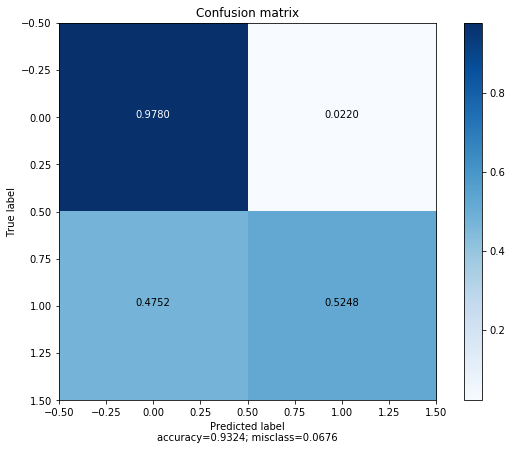

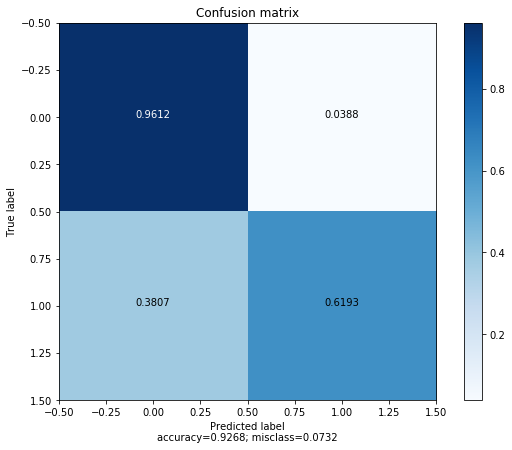

0.93243125
0.6296916996047429


In [194]:
train_prediction_prob = gbm.predict(train_fin, num_iteration=gbm.best_iteration)
threshold_acc_score = 0
acc_score_thres = 0.1
threshold_f1_score = 0
f1_score_thres = 0.1
for ii in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
  predictions_lgbm_01 = np.where(train_prediction_prob > ii, 1, 0)
  acc_lgbm = accuracy_score(train_y_cleaned,predictions_lgbm_01)
  f1_score_lgbm = f1_score(train_y_cleaned,predictions_lgbm_01)
  if threshold_acc_score<acc_lgbm:
    threshold_acc_score=acc_lgbm
    acc_score_thres=ii
  if threshold_f1_score<f1_score_lgbm:
    threshold_f1_score=f1_score_lgbm
    f1_score_thres=ii

  
predictions_lgbm_02 = np.where(train_prediction_prob > acc_score_thres, 1, 0)
cm_02 = confusion_matrix(train_y_cleaned, predictions_lgbm_02)
plot_confusion_matrix(cm_02)

predictions_lgbm_02 = np.where(train_prediction_prob > f1_score_thres, 1, 0)
cm_02 = confusion_matrix(train_y_cleaned, predictions_lgbm_02)
plot_confusion_matrix(cm_02)

print(threshold_acc_score)
print(threshold_f1_score)

위의 Confusion Matrix는 정확도가 가장 높을 때

아래는 F1 score가 가장 높을 때의 Matrix

Tunning은 GridSearch를 활용하면 시간이 오래 걸리는 관계로,

대략적으로 튜닝할 수 있는 방법인,

Test 셋에 대한 평가 점수와 Train 셋에 대한 평가 점수가 비슷하면, 모델 향상 가능성이 있다고 판단하여, 복잡한 모델을 생성하며 고도화하고,

두 점수 차이가 벌어지면 Overfitting 되었다고 판단하여 규제를 추가했습니다.

# 5. Result

분류 결과를 분석하기 위해 Feature 별 중요도를 나타내는 그래프,

Confusion Matrix,

ROC 그래프를 이용했습니다.

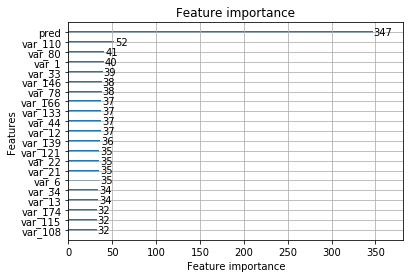

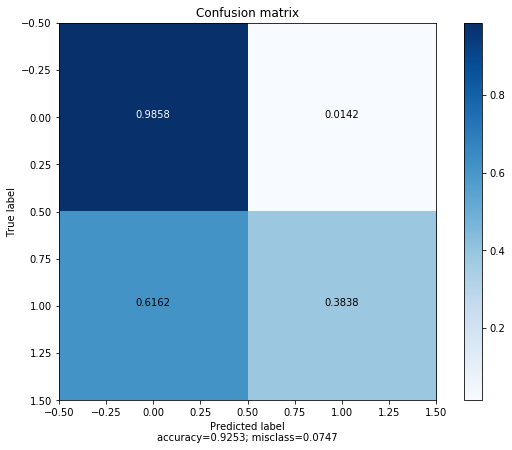

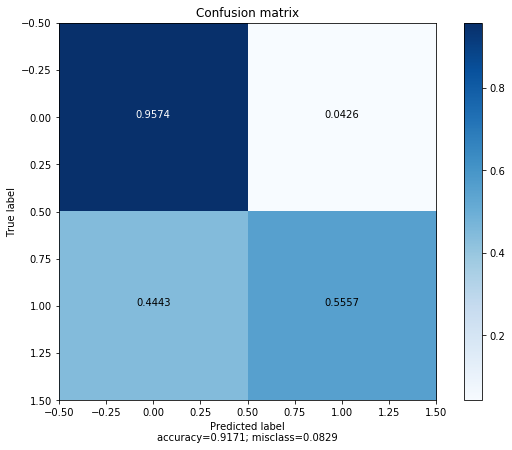

0.9253
0.5738505008990497


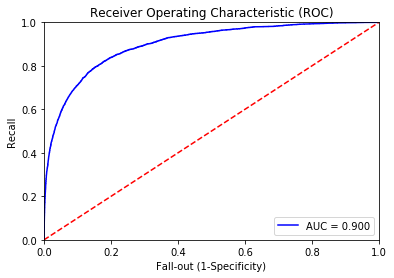

AUC score: 0.8997269074306068


In [195]:
# copy data
y_test = test_y

# show feature importance
lgb.plot_importance(gbm, max_num_features=21, importance_type='split')


#Print accuracy
test_prediction_prob = gbm.predict(test_fin, num_iteration=gbm.best_iteration)
threshold_acc_score = 0
acc_score_thres = 0.1
threshold_f1_score = 0
f1_score_thres = 0.1
for ii in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
  predictions_lgbm_01 = np.where(test_prediction_prob > ii, 1, 0)
  acc_lgbm = accuracy_score(y_test,predictions_lgbm_01)
  f1_score_lgbm = f1_score(y_test,predictions_lgbm_01)
  if threshold_acc_score<acc_lgbm:
    threshold_acc_score=acc_lgbm
    acc_score_thres=ii
  if threshold_f1_score<f1_score_lgbm:
    threshold_f1_score=f1_score_lgbm
    f1_score_thres=ii

predictions_lgbm_02 = np.where(test_prediction_prob > acc_score_thres, 1, 0)
cm_02 = confusion_matrix(y_test, predictions_lgbm_02)
plot_confusion_matrix(cm_02)

predictions_lgbm_02 = np.where(test_prediction_prob > f1_score_thres, 1, 0)
cm_02 = confusion_matrix(y_test, predictions_lgbm_02)
plot_confusion_matrix(cm_02)

print(threshold_acc_score)
print(threshold_f1_score)   
    
    
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, test_prediction_prob)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

가장 위의 그래프는 Feature의 중요도를 나타내는 그래프로, 확률 Feature가 다른 변수들에 비해 압도적으로 중요함을 알 수 있음

아래의 그래프 두개는 각각 정확도가 높을 때, F1 score가 높을 때의 그래프

가장 아래의 그래프는 예측 확률 결과값에 대한 ROC 그래프

AUC가 약 0.9임을 확인

처음 데이터 분석 단계에서 Label별 분포의 차이가 적고, 유사한 형태를 가지고 있어, 분류하기 어려운 점이 Confusion matrix에서도 드러남을 알 수 있습니다.

거래하지 않을 것 같은 고객에 대해서는 정확도가 높으나,

거래할 것 같은 고객에 대한 분류 정확도가 작습니다. 그러므로, 모델 활용 목적에 따라, Threshold값을 결정해야 합니다.

Naive Bayse 룰을 이용하여 확률 변수를 이용하여 모델링을 할 경우 Label별로 분포가 큰 문제에서도 안정적인 모델을 만들어 낼 수 있음을 확인했습니다.

# Kaggle Test

아래의 과정은 Kaggle에 있는 테스트셋을 이용하여 모델 평가하기 위한 전처리 및 예측 과정입니다.

확률 Feature을 생성하기 위한 집단의 분포는 Train set을 활용하였고, Scaling에 사용된 최소값, 최대값 또한 Train Set을 활용했습니다.

In [49]:
sub_test = pd.read_csv("gdrive/My Drive/Colab Notebooks/Kaggle/Santander_prediction/Data/test.csv")
print(sub_test.shape)
sub_test.head()

(200000, 201)


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [50]:
sub_test_x = sub_test[sub_test.columns[1:]]
sub_test_x_copy = sub_test_x.copy()

#Output DataFrame
statistic_df_2 = pd.DataFrame()
reg_df_2 = pd.DataFrame()

#Create Statistic DataFrame
statistic_df_2["mean"] = sub_test_x_copy.apply(cal_mean, axis=1)
statistic_df_2["std"] = sub_test_x_copy.apply(cal_std, axis=1)
statistic_df_2["median"] = sub_test_x_copy.apply(cal_median, axis=1)
statistic_df_2["kurtosis"] = sub_test_x_copy.apply(cal_kurtosis, axis=1)
statistic_df_2["skew"] = sub_test_x_copy.apply(cal_skew, axis=1)
statistic_df_2["sum"] = sub_test_x_copy.apply(cal_sum, axis=1)
statistic_df_2_min = statistic_df_2.min(axis=0)
statistic_df_2_max = statistic_df_2.max(axis=0)
statistic_df_2_range = statistic_df_2_max - statistic_df_2_min
statistic_df_2  = (statistic_df_2-statistic_df_2_min)/statistic_df_2_range
print("Creating Statistic DF is done")

#Create Reg DataFrame
reg_df_2 = (sub_test_x_copy-x_min)/x_range
print("Creating Reg DF is done")

#Output DF
sub_merge_data = pd.concat([reg_df_2, statistic_df_2], ignore_index=True, axis=1)
cols = list(sub_test_x.columns)+['mean','std','median','kurtosis','skew','sum']
sub_merge_data.columns= cols

Creating Statistic DF is done
Creating Reg DF is done


In [51]:
pred_sub = [0]*len(sub_test_x); ct = 0

# Transform value to prob & checking prob performance
for r in sub_test_x.index:
    p = 0.1
    for i in range(200):
        p *= 10*getp2(i,sub_test_x.iloc[r,i])
    if ct%25000==0: print('train',r,'has target =',sub_test_x.iloc[r,1],'and prediction =',p)
    pred_sub[ct]=p; ct += 1

train 0 has target = 7.7798 and prediction = 0.2409627931124035
train 25000 has target = 1.8205 and prediction = 0.09350397306684285
train 50000 has target = -8.9729 and prediction = 0.03405073638311492
train 75000 has target = -8.1324 and prediction = 0.023229922574155848
train 100000 has target = 0.0834 and prediction = 0.025722339387690234
train 125000 has target = -1.2839 and prediction = 0.04178789647859754
train 150000 has target = -3.2789 and prediction = 0.37656091477012865
train 175000 has target = 1.1440000000000001 and prediction = 0.05900109276760226


In [52]:
pred_sub_df = pd.DataFrame()
pred_sub_df["pred"]=pred_sub


# merge with prediction data
sub_fin = pd.concat([sub_merge_data, pred_sub_df], axis=1)
sub_fin.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,mean,std,median,kurtosis,skew,sum,pred
0,0.530895,0.897837,0.628717,0.714035,0.577429,0.607399,0.574061,0.578182,0.611866,0.665064,0.474766,0.502258,0.438561,0.230092,0.468781,0.510767,0.408172,0.257767,0.500738,0.605147,0.248951,0.488649,0.345611,0.506248,0.272898,0.747316,0.369578,0.406506,0.551090,0.478163,0.654120,0.395085,0.700669,0.401839,0.436918,0.633793,0.359617,0.361495,0.445720,0.774263,...,0.623377,0.476344,0.327433,0.597524,0.598001,0.643872,0.748319,0.453933,0.513266,0.601575,0.336894,0.401178,0.476357,0.506588,0.556098,0.190180,0.309393,0.792989,0.601959,0.485803,0.342830,0.355245,0.639518,0.354253,0.749230,0.184153,0.473444,0.260824,0.808435,0.570992,0.788006,0.454218,0.453902,0.598803,0.532317,0.634985,0.100155,0.542638,0.598803,0.240963
1,0.402316,0.641132,0.533050,0.391227,0.374418,0.574572,0.601977,0.594479,0.294934,0.259223,0.491108,0.595236,0.556029,0.310479,0.322132,0.397789,0.368716,0.720196,0.759844,0.264546,0.478758,0.223696,0.530179,0.330933,0.646323,0.417828,0.476199,0.245640,0.550679,0.434109,0.482189,0.518720,0.508464,0.493471,0.236019,0.435414,0.664165,0.270211,0.531100,0.419264,...,0.786482,0.611021,0.400537,0.435125,0.354015,0.657179,0.406767,0.289998,0.361477,0.605759,0.205665,0.421433,0.613341,0.649708,0.736407,0.282714,0.375653,0.695041,0.386065,0.590647,0.553481,0.461309,0.536625,0.754687,0.593904,0.393414,0.728803,0.357802,0.597395,0.391146,0.647505,0.642395,0.269282,0.370460,0.456167,0.411297,0.167948,0.439534,0.370460,0.254457
2,0.247744,0.184314,0.465517,0.532882,0.471178,0.852630,0.417628,0.667081,0.582317,0.598409,0.406726,0.532598,0.197147,0.355782,0.706688,0.407587,0.534123,0.681207,0.608299,0.703398,0.487465,0.379796,0.504491,0.432095,0.225739,0.452385,0.220914,0.627772,0.787377,0.458341,0.508378,0.421012,0.766636,0.741816,0.617246,0.682482,0.544535,0.473420,0.398329,0.503023,...,0.555433,0.321966,0.668681,0.458777,0.593473,0.450138,0.470946,0.653146,0.717662,0.384125,0.683273,0.336089,0.578142,0.548625,0.350891,0.418995,0.644494,0.683527,0.536832,0.305360,0.647601,0.286006,0.567118,0.398372,0.705125,0.485230,0.464437,0.222877,0.772498,0.218283,0.182324,0.681825,0.236092,0.617431,0.544034,0.621983,0.120479,0.532451,0.617431,0.201828
3,0.402671,0.539775,0.574667,0.496900,0.342485,0.719189,0.424956,0.681060,0.671982,0.471566,0.526396,0.485843,0.506599,0.706254,0.556771,0.595141,0.543051,0.330614,0.244056,0.717445,0.543857,0.382893,0.415093,0.826649,0.553429,0.758853,0.632524,0.498651,0.482042,0.634585,0.812975,0.411141,0.719505,0.310431,0.284595,0.340859,0.634139,0.340663,0.633294,0.776710,...,0.667937,0.622210,0.488234,0.692547,0.641878,0.220240,0.813715,0.376975,0.418638,0.493620,0.574557,0.615434,0.420469,0.911671,0.492816,0.579057,0.351467,0.423290,0.737676,0.238974,0.396538,0.362694,0.586592,0.721883,0.606357,0.456776,0.511046,0.337572,0.882547,0.558429,0.541227,0.327874,0.521821,0.591697,0.191438,0.528191,0.117185,0.525306,0.591697,0.293623
4,0.563364,0.586569,0.696941,0.586339,0.365890,0.482541,0.739656,0.235211,0.653272,0.426619,0.655655,0.527041,0.546520,0.542150,0.266748,0.539836,0.648344,0.690824,0.547140,0.554842,0.191589,0.446363,0.607551,0.652507,0.548732,0.619933,0.823331,0.398458,0.477248,0.658310,0.378639,0.470476,0.267460,0.571943,0.590596,0.493393,0.552789,0.608828,0.340105,0.485442,...,0.530901,0.543983,0.675889,0.408278,0.494910,0.456260,0.600403,0.365239,0.549301,0.361584,0.330086,0.347074,0.654547,0.598454,0.552252,0.335017,0.502866

In [ ]:
sub_prediction_prob = gbm.predict(sub_fin,num_iteration=gbm.best_iteration)
submission = pd.DataFrame()
submission["ID_code"]=sub_test["ID_code"]
submission["target"]=sub_prediction_prob

In [ ]:
submission.to_csv("gdrive/My Drive/Colab Notebooks/Kaggle/Santander_prediction/Data/submit_v01.csv", index=False)

캐글 Test 셋에 대한 정확도 점수 : 0.899

캐글 Test 셋에서 Label 0과 1의 분포가 5:5임을 감안한다면, Label 1에 대한 분류 정확도도 괜찮은 것으로 판단됩니다.